# Training to Detect Beat Position in Window

The idea is to train a kernel to detect beats.  It is assumed that there is typically some sort of percussion on the beat, which the network can pick up on.

In [89]:
%matplotlib notebook
import os.path
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
plt.ion()
from importlib import reload

In [90]:
# load local code
import sys
sys.path.append('src')
import nf_train.data as nfd
reload(nfd)
None

In [91]:
# initialize data source
data_dir = nfd.DataDir('../nf_data/run2/')
print(f"Data contains {len(data_dir.processed)} songs.")
print(f"{len(data_dir.failed)} songs failed to process.")
print(f"One second contains {data_dir.params['rate']} samples.")
print(f"One sample has {data_dir.params['n_filters']} features.")

Data contains 43 songs.
0 songs failed to process.
One second contains 100.0 samples.
One sample has 30 features.


## Generate Training Data



In [308]:
def get_taps(beats):
    """Returns a tapped location based on a true beat location."""
    offsets = np.random.choice([-2, -1, 0, 1, 2],
                              p=[0.05, 0.2, 0.5, 0.2, 0.05],
                              size=len(beats))
    taps = np.sum(np.vstack([beats, offsets]), axis=0)
    return taps

def get_target(tap, beat, r):
    t = torch.zeros((r + 1 + r), dtype=torch.float)
    i = beat - tap + r
    t[i] = 1
    return torch.tensor(i, dtype=torch.long)

def get_sample(data, beat, tap, r, pre, post):
    pre = pre + r
    post = post + r
    inp = data.get_hist_frame(tap, pre, post)
    if inp is None:
        return None
    if torch.max(inp) < 0.9:
        return None
    target = get_target(tap, beat, r)
    return {
        'info': data.info,
        'input': inp,
        'target': target,
    }

def get_tr_va_data(data, r, pre, post, ratio):
    """data is a song object."""
    # get taps and beats
    beat_locs = data.beat_indices
    tap_locs = get_taps(beat_locs)
    samples = [get_sample(data, beat, tap, r, pre, post)
               for beat, tap in zip(beat_locs, tap_locs)]
    samples = [s for s in samples if s is not None]
    random.shuffle(samples)
    print(f"samples: {len(samples)}")
    split = round(len(samples) * ratio)
    tr_samples, va_samples = samples[:split], samples[split:]
    return tr_samples, va_samples

def tr_va_from_files(data_dir, files, r, pre, post, ratio):
    tr_samples, va_samples = [], []
    for file in files:
        data = data_dir.get_file(file)
        t, v = get_tr_va_data(data, r, pre, post, ratio)
        tr_samples.extend(t)
        va_samples.extend(v)
    return tr_samples, va_samples        

In [309]:
r, pre, post = 2, 2, 2
tr_ratio = 0.7
d = data_dir.params['n_filters']

files = [
    '9397943_LSD_Original_Mix.pickle'
]

t, v = tr_va_from_files(data_dir, files, r, pre, post, tr_ratio)

samples: 621


## Neural Network

In [310]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [327]:
class SimpleConv(nn.Module):
    def __init__(self, r, pre, post, d):
        super(SimpleConv, self).__init__()
        self.t = pre + r + 1 + r + post
        self.d = d
        self.c = r + 1 + r
        self.conv = nn.Conv2d(1, 1, (pre + 1 + post, d), bias=True)
        self.pool = nn.Conv1d(1, 1, 3, bias=True, padding=1)
        # conv layer with kernel (pre + 1 + post, d) -> (1, r + 1 + r)
        # softmax
        
    def forward(self, inp):
        out = inp
        out = self.conv(out)
        out = out.squeeze(dim=3)
        out = self.pool(out)
        out = out.squeeze(dim=1)
        #print(out.shape)
        return out

In [328]:
def data_loader(samples):
    return DataLoader(
        samples,
        shuffle=True,
        batch_size=2,
        collate_fn=lambda samples: {
            'input': torch.unsqueeze(torch.stack([s['input'] for s in samples], axis=0), 1),
            'target': torch.stack([s['target'] for s in samples], axis=0)
        },
    )

def validate_model(model, data_loader):
    model.eval()
    correct = 0
    count = 0
    for sample in data_loader:
        x = sample['input']
        out = model(x)
        beat = torch.argmax(out, axis=1)
        #print(beat)
        #print(sample['target'])
        correct += torch.sum(beat == sample['target'])
        count += len(sample['target'])
    v = float(correct)/float(count)
    return v

def train(model, tr_set, va_set, epochs=10):
    optimizer = torch.optim.Adam(model.parameters())
    tr_loader = data_loader(tr_set)
    va_loader = data_loader(va_set)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        for sample in tr_loader:
            x = sample['input']
            y = sample['target']
            out = model(x)
            #print(f"out: {out.shape} {y.shape}")
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        tr_acc = validate_model(model, tr_loader)
        va_acc = validate_model(model, va_loader)
        print(f"Acc tr: {tr_acc:.02f}; va: {va_acc:.02f}")

In [336]:
r, pre, post = 2, 10, 20
tr_ratio = 0.7
d = data_dir.params['n_filters']

files = [
    '9397943_LSD_Original_Mix.pickle',
    #'9928484_Orchid_Original_Mix.pickle',
    #'6450638_Iyewaye_Original_Mix.pickle',
    #'3887937_Pistolero_Astrix_Remix.pickle',
    '7811712_Edging_Forward_Original_Mix.pickle',
    '7600824_Tripical_Moon_Original_Mix.pickle',
    #'10 - Bratenschneider - Trigger.pickle',
    '10924655_Take_Kurie__Original_Mix__Original_Mix.pickle',
    '06 - Nicorus - Canis Lupus.pickle',
    #'8013109_Daydream_Original_Mix.pickle',
    #'8602606_Here_We_Go_Again_2016_Pro_Mix.pickle',
]

t, v = tr_va_from_files(data_dir, files, r, pre, post, tr_ratio)

samples: 635
samples: 749
samples: 773
samples: 757
samples: 868


In [337]:
model = SimpleConv(r, pre, post, d)
train(model, t, v, epochs=5)

Acc tr: 0.85; va: 0.83
Acc tr: 0.88; va: 0.84
Acc tr: 0.89; va: 0.85
Acc tr: 0.90; va: 0.86
Acc tr: 0.90; va: 0.86



<IPython.core.display.Javascript object>


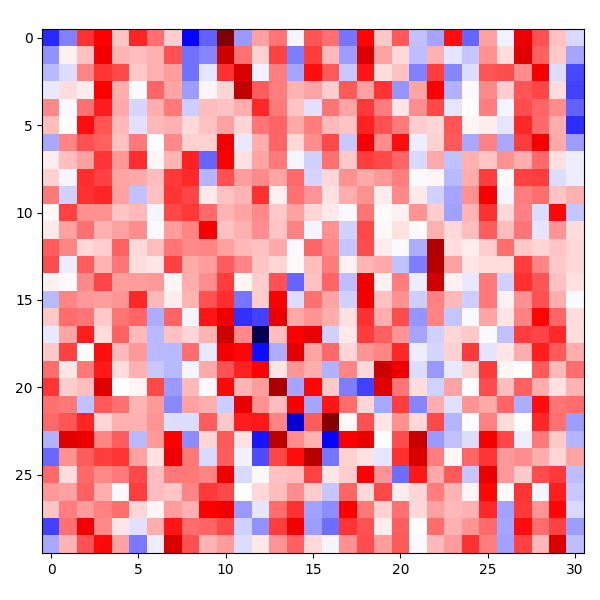

In [338]:
w = model.conv.weight[0].detach().numpy()[0]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.imshow(np.flip(w.T, axis=0), cmap='seismic')
fig.tight_layout()

In [252]:
model.save_to_pickle("model.pickle")

In [249]:
# TODO: normalize values.  Add noise on input.  Try L1 reg. .. batching!
# also I should save the parameters at data generation, carry them through here and 
# save them in the model.pickle to load later